### Random Forest

Step 1. Reading the processed dataset

In [5]:
import os
import pandas as pd

# Extraer datos
# Se ha mantenido todos los Excels, pero con el DecisionTreeClassifier solo se usan los datos naturales
# es decir, con outliers y sin outliers
BASE_PATH = "../data/processed"
TRAIN_PATHS = [
    "X_train_con_outliers.xlsx",
    "X_train_sin_outliers.xlsx"
]

TRAIN_DATASETS = []
for path in TRAIN_PATHS:
    TRAIN_DATASETS.append(
        # pd.read_excel(BASE_PATH + "/" + path)
        pd.read_excel(f"{BASE_PATH}/{path}")
        # pd.read_excel(os.path.join(BASE_PATH, path))
    )

TEST_PATHS = [
    "X_test_con_outliers.xlsx",
    "X_test_sin_outliers.xlsx"
]

TEST_DATASETS = []
for path in TEST_PATHS:
    TEST_DATASETS.append(
        pd.read_excel(f"{BASE_PATH}/{path}")
    )

y_train = pd.read_excel(f"{BASE_PATH}/y_train.xlsx")
y_test = pd.read_excel(f"{BASE_PATH}/y_test.xlsx")

Step 2: Initialization and training of the model

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# crea el modelo, entrena el modelo, guardas el target de train y de test. Sacar la precisión para comparar cual es el mejor de todos
results_accuracy = []

for index, dataset in enumerate(TRAIN_DATASETS):
    print(index)
    model = RandomForestClassifier(random_state = 42)
    model.fit(dataset, y_train)
    
    y_pred_train = model.predict(dataset)   # x_train
    y_pred_test = model.predict(TEST_DATASETS[index])   # x_text

    results_accuracy.append(
        {
            "train": accuracy_score(y_train, y_pred_train),
            "test": accuracy_score(y_test, y_pred_test)
        }
    )
 
    # print tiempo que ha tardado
results_accuracy

0
1


[{'train': 1.0, 'test': 0.7207792207792207},
 {'train': 1.0, 'test': 0.7207792207792207}]

Se observa overfitting, pero es normal en modelos de Decission Tree y Random Forest, hago la hiperparametrización

In [7]:
from sklearn import linear_model
from sklearn.model_selection import ParameterGrid, GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")
path_train = "X_train_con_outliers.xlsx"
path_test = "X_test_con_outliers.xlsx"
winner_train = pd.read_excel(f"{BASE_PATH}/{path_train}")
winner_test = pd.read_excel(f"{BASE_PATH}/{path_test}")

In [8]:
model = RandomForestClassifier(random_state=42)
# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'criterion': ['gini', 'entropy'],  
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 20, 50],  # None significa sin límite
    'min_samples_split': [2, 5, 10],  # Reducido para eficiencia
    'min_samples_leaf': [1, 2, 5],  # Valores más comunes
    'max_features': ['sqrt', 'log2'],  # 'auto' (deprecated) == 'sqrt'
    'bootstrap': [True, False],  # Si se usa muestreo con reemplazo
}
# El mejor
# param_grid = {
#     'criterion' : ['entropy'],
#     'max_depth' : [5], 
#     'max_leaf_nodes' : [10],
#     'min_samples_leaf' : [10]
# }
# GridSearchCV para encontrar los mejores parámetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
train_regularized = grid_search.fit(winner_train, y_train)

final_model = train_regularized.best_estimator_
final_model

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=9,
                       min_samples_leaf=5, n_estimators=200, random_state=42)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=9,
                       min_samples_leaf=5, n_estimators=200, random_state=42)

Step 3: Model prediction

In [9]:
y_pred_train = final_model.predict(winner_train)
accuracy_score(y_pred_train, y_train)

0.9576547231270358

In [10]:
y_pred_test = final_model.predict(winner_test)
accuracy_score(y_pred_test, y_test)

0.7532467532467533

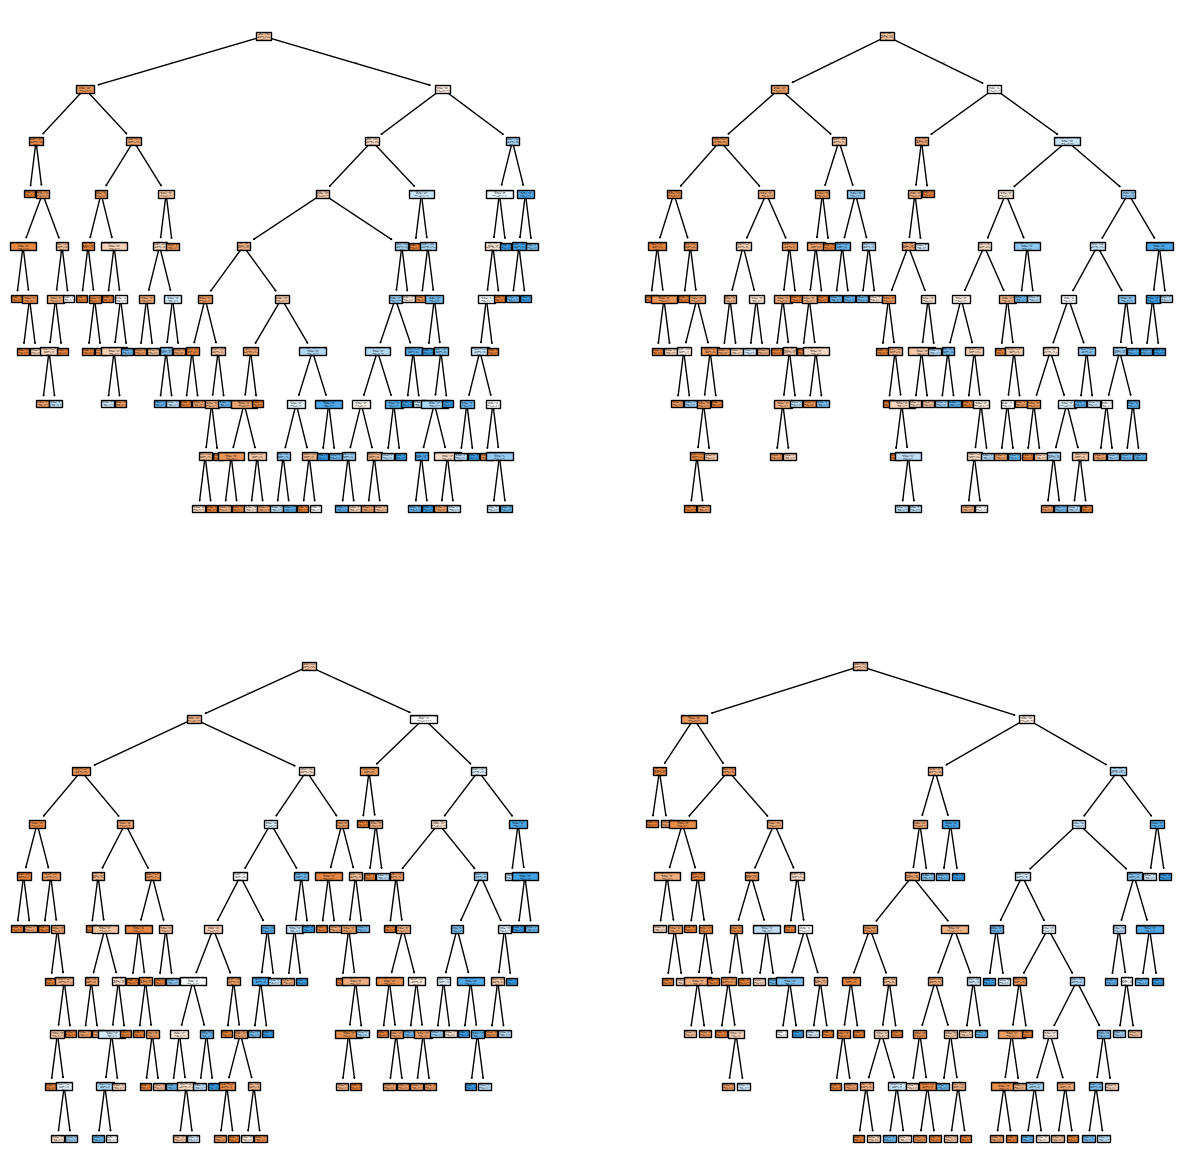

In [11]:
# Representar 4 de todos los que hay. Para practicar.
import matplotlib.pyplot as plt
from sklearn import tree

fig, axis = plt.subplots(2, 2, figsize = (15, 15))

# We show the first 4 trees out of the 100 generated (default)
tree.plot_tree(final_model.estimators_[0], ax = axis[0, 0], feature_names = list(winner_train.columns), class_names = ["0", "1"], filled = True)
tree.plot_tree(final_model.estimators_[1], ax = axis[0, 1], feature_names = list(winner_train.columns), class_names = ["0", "1"], filled = True)
tree.plot_tree(final_model.estimators_[2], ax = axis[1, 0], feature_names = list(winner_train.columns), class_names = ["0", "1"], filled = True)
tree.plot_tree(final_model.estimators_[3], ax = axis[1, 1], feature_names = list(winner_train.columns), class_names = ["0", "1"], filled = True)

plt.show()

Step 4: Saving the model

In [ ]:
from pickle import dump
base_path = os.getcwd()
model_path = "../models/random_forest_classifier_default_42.pkl"
complete_path = os.path.join(base_path, model_path)

In [13]:

dump(final_model, open(complete_path, "wb"))

FEATURE SELECTION

In [36]:
# Se prueba el Feature Selection 
# Al tratarse de un valor del % se considera aceptable para el modelo
base_path = "../data/processed/assets"
train_paths = "clean_with_outliers__train_k_5.csv"
x_train = pd.read_csv(f"{base_path}/{train_paths}", sep=",")


test_paths = "clean_with_outliers__test_k_5.csv"
x_test = pd.read_csv(f"{base_path}/{test_paths}", sep=",")

In [37]:
# GridSearchCV para encontrar los mejores parámetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
train_regularized = grid_search.fit(x_train, y_train) 

final_model_feature_selection = train_regularized.best_estimator_

final_model_feature_selection
# Guardar en pickle porque tienes los hiperparámetros y el modelo. _best_estimator

RandomForestClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50, random_state=42)

k=4, RandomForestClassifier(max_depth=5, min_samples_leaf=2, random_state=42)

    Train 0.8452768729641694
    Test 0.7597402597402597

k=5
RandomForestClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50, random_state=42)
                       
    Train   0.8175895765472313
    Test   0.7662337662337663

k=6, RandomForestClassifier(max_depth=6, min_samples_leaf=2, n_estimators=200,
                       random_state=42)
    
    Train  0.8859934853420195
    Test 0.7532467532467533

k=7, RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=9,
                       min_samples_leaf=5, n_estimators=50, random_state=42)

    Train   0.9478827361563518
    Test   0.7597402597402597

In [38]:
y_pred_train_feature_selection = final_model_feature_selection.predict(x_train)
accuracy_score(y_pred_train_feature_selection, y_train)

0.8175895765472313

In [39]:
y_pred_test_feature_selection = final_model_feature_selection.predict(x_test)
accuracy_score(y_pred_test_feature_selection, y_test)

0.7662337662337663

In [40]:
from pickle import dump
base_path = os.getcwd()
model_path = "../models/decission_tree_classifier_default_42_k5.pkl"
complete_path = os.path.join(base_path, model_path)
dump(model, open(complete_path, "wb"))

In [ ]:
from sklearn.metrics import recall_score

score_train = recall_score(y_pred_train_feature_selection, y_pred_train) # falsos positivos
score_test = recall_score(y_pred_test_feature_selection, y_pred_test)

print(f'Score train: {score_train}')    #Buenos valores, si son muy dispares es malo
print(f'Score test: {score_test}')

Score train: 0.8711656441717791
Score test: 0.9411764705882353
